In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
#from fuzzywuzzy import process
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from tabulate import tabulate

In [34]:
df = pd.read_csv('EDA-Fase2.csv')
df.head()

,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,AreaIsGreaterFlag,...,Structure_ls,Structure_b,Remarks_dealings including private road,Remarks_dealings in which auction or arbiter participates,Remarks_dealings of adjacent land,Remarks_dealings between related objects,Remarks_dealings including special circumstances,Remarks_dealings including valueless house,Remarks_dealings of real estate that includes wound etc.,Remarks_dealings of real estate to which mortgage etc. are set
0,1101,hokkaido,"chuo ward,sapporo city",asahigaoka,maruyamakoen,28.0,28.0,86000000,1100,False,...,0,0,0,0,0,0,0,0,0,0
1,1101,hokkaido,"chuo ward,sapporo city",asahigaoka,maruyamakoen,27.0,27.0,38000000,310,False,...,0,0,0,0,0,0,0,0,0,0
2,1101,hokkaido,"chuo ward,sapporo city",asahigaoka,maruyamakoen,20.0,20.0,19000000,95,False,...,0,0,0,0,0,0,0,0,0,0
3,1101,hokkaido,"chuo ward,sapporo city",asahigaoka,maruyamakoen,26.0,26.0,5000000,290,False,...,0,0,0,0,0,0,0,0,0,0
4,1101,hokkaido,"chuo ward,sapporo city",asahigaoka,maruyamakoen,23.0,23.0,25000000,430,False,...,0,0,0,0,0,0,0,0,0,0


In [35]:
to_test=['MunicipalityCode',"Municipality", 'Prefecture', 'DistrictName', 'NearestStation']
to_delete = to_test
df[to_test]

,MunicipalityCode,Municipality,Prefecture,DistrictName,NearestStation
0,1101,"chuo ward,sapporo city",hokkaido,asahigaoka,maruyamakoen
1,1101,"chuo ward,sapporo city",hokkaido,asahigaoka,maruyamakoen
2,1101,"chuo ward,sapporo city",hokkaido,asahigaoka,maruyamakoen
3,1101,"chuo ward,sapporo city",hokkaido,asahigaoka,maruyamakoen
4,1101,"chuo ward,sapporo city",hokkaido,asahigaoka,maruyamakoen
...,...,...,...,...,...
3887066,47382,"yonaguni town,yaeyama county",okinawa prefecture,aza yonaguni,NaN
3887067,47382,"yonaguni town,yaeyama county",okinawa prefecture,aza yonaguni,NaN
3887068,47382,"yonaguni town,yaeyama county",okinawa prefecture,aza yonaguni,NaN
3887069,47382,"yonaguni town,yaeyama county",okinawa prefecture,aza yonaguni,NaN


In [4]:
for col in to_test:
    print(df[col].value_counts(dropna=False))

MunicipalityCode
13112    26167
13111    22489
13120    21972
13121    18381
13115    17734
         ...  
15586        9
7364         6
46304        6
47356        2
46303        2
Name: count, Length: 1893, dtype: int64
Municipality
setagaya ward                          26167
ota ward                               22489
nerima ward                            21972
adachi ward                            18381
suginami ward                          17734
                                       ...  
awashimaura village,iwafune county         9
hinoemata village,minamiaizu county        6
toshima village,kagoshima county           6
tonaki village,shimajiri county            2
mishima village,kagoshima county           2
Name: count, Length: 1879, dtype: int64
Prefecture
tokyo                   402959
kanagawa prefecture     278903
osaka prefecture        233517
saitama prefecture      208353
aichi prefecture        201604
hokkaido                185129
chiba prefecture        183766
hy

In [5]:
print("Data rows: ", df.shape[0])
for col in to_test:
    print(col)
    print("Null: ", df[col].isnull().sum())
    print("Amount categories: ", len(df[col].unique()))

Data rows:  3887071
MunicipalityCode
Null:  0
Amount categories:  1893
Municipality
Null:  0
Amount categories:  1879
Prefecture
Null:  0
Amount categories:  47
DistrictName
Null:  8180
Amount categories:  68669
NearestStation
Null:  557898
Amount categories:  8423


There is a big amount of categories, an attemp to reduce them is performed in following cells.

first a searching of types is performed.

In [6]:
def look_for_similar_elements(dfi, column):
    resultados = {}
    
    # Obtener nombres únicos de la columna especificada
    nombres_unicos = dfi[column].unique()
    nombres_lista = list(nombres_unicos)
    
    # Manejar NaNs
    nombres_lista = np.where(pd.isna(nombres_lista), 'NO-'+column, nombres_lista).tolist()
    
    # Crear la matriz TF-IDF
    vectorizer = TfidfVectorizer(ngram_range=(1, 3)).fit_transform(nombres_lista)
    vectors = vectorizer.toarray()
    
    # Calcular la similitud del coseno
    cosine_sim = cosine_similarity(vectors)
    
    for i in tqdm(range(len(nombres_lista)), desc="Buscando nombres similares"):
        nombre = nombres_lista[i]
        # Obtener índices de similitudes por encima del umbral (por ejemplo, 0.3)
        indices_similares = [j for j in range(i + 1, len(cosine_sim[i])) if cosine_sim[i][j] > 0.3 and i != j]
        
        # Guardar los nombres similares en el diccionario
        similares = [nombres_lista[j] for j in indices_similares] if indices_similares else ["NO SIMILAR"]
        
        resultados[nombre] = ", ".join(similares) if similares else '' 
    
    # Crear el DataFrame asegurando que cada entrada sea una lista
    df_similares = pd.DataFrame.from_dict(resultados, orient='index', columns=['similares'])
    
    # Eliminación de Estaciones que no tienen similares
    df_similares = df_similares[~df_similares['similares'].str.contains("NO SIMILAR")]
    
    print("\nNombres Similares:")
    print(df_similares)

In [7]:
look_for_similar_elements(df.copy(), "NearestStation")

Buscando nombres similares: 100%|█████████████████████████████████████████████████| 8423/8423 [00:12<00:00, 655.27it/s]



Nombres Similares:
                                                                similares
NO-NearestStation                                                      no
odori                                           nihon-odori, yakuin-odori
nango 18-chome                       nishi 18-chome, nango 7-chome, nango
bus center mae          kyukaniryo center mae, trade center mae, iryo ...
sapporo (sapporoshiei)  sapporo (jr), hiragishi (sapporoshiei), shiroi...
...                                                                   ...
oita                    maki (oita), beppu (oita), imazu (oita), shona...
miyazaki                kano (miyazaki), uchiumi (miyazaki), undokoen ...
kagoshima               nikenjaya (kagoshima), shirasawa (kagoshima), ...
taniyama (jr)                                           taniyama (shiden)
kenchomae (okinawa)                            shiritsubyoinmae (okinawa)

[725 rows x 1 columns]


In [8]:
df_filtered = df[df['NearestStation'].str.contains('imazu (oita)', na=False,regex=False)]
df_filtered = df_filtered[[ 'MunicipalityCode', 'Prefecture', 'Municipality', 'DistrictName', 'NearestStation']]
print(tabulate(df_filtered.head(), headers='keys', tablefmt='psql'))

+---------+--------------------+-----------------+----------------+----------------+------------------+
|         |   MunicipalityCode | Prefecture      | Municipality   | DistrictName   | NearestStation   |
|---------+--------------------+-----------------+----------------+----------------+------------------|
| 3711440 |              44203 | oita prefecture | nakatsu city   | oaza akasako   | imazu (oita)     |
| 3711452 |              44203 | oita prefecture | nakatsu city   | oaza inumaru   | imazu (oita)     |
| 3711453 |              44203 | oita prefecture | nakatsu city   | oaza inumaru   | imazu (oita)     |
| 3711454 |              44203 | oita prefecture | nakatsu city   | oaza inumaru   | imazu (oita)     |
| 3711455 |              44203 | oita prefecture | nakatsu city   | oaza inumaru   | imazu (oita)     |
+---------+--------------------+-----------------+----------------+----------------+------------------+


There is data redundanci as some station contains info about the prefecture. they will be deleted

In [9]:
df['NearestStation'] = df['NearestStation'].str.replace(r'\s*\(.*?\)\s*', '', regex=True)

In [10]:
look_for_similar_elements(df.copy(), "NearestStation")

Buscando nombres similares: 100%|█████████████████████████████████████████████████| 7951/7951 [00:23<00:00, 337.06it/s]



Nombres Similares:
                                                           similares
NO-NearestStation                                                 no
odori                                      nihon-odori, yakuin-odori
nango 18-chome                  nishi 18-chome, nango 7-chome, nango
bus center mae     kyukaniryo center mae, trade center mae, iryo ...
sapporo                                           sapporo beer teien
...                                                              ...
shin-iizuka                                                   iizuka
chikuzen-uchino                                      chikuzen-yamate
isahaya                                                  hon-isahaya
kumamoto                                              nishi-kumamoto
yatsushiro                                           shin-yatsushiro

[196 rows x 1 columns]


In [11]:
col = "NearestStation"
print(col)
print("Null: ", df[col].isnull().sum())
print("Amount categories: ", len(df[col].unique()))

NearestStation
Null:  557898
Amount categories:  7951


There are some statios that contains the name of the city in the name of the satation https://en.wikipedia.org/wiki/Shin-Yatsushiro_Station, but in this case is the actual name of the station, therefore it will no be deleted.

500 rows were deleted, but tere are 7951 still to 

In [12]:
#df_filtrado = df.loc[df['Municipality'].str.lower() == 'awashimaura village, iwafune county']

df_filtered = df[df['Municipality'].str.contains('awashimaur', na=False,regex=False)]
df_filtered = df_filtered[to_test]
print(tabulate(df_filtered.head(), headers='keys', tablefmt='psql'))

+---------+--------------------+------------------------------------+--------------------+----------------+------------------+
|         |   MunicipalityCode | Municipality                       | Prefecture         | DistrictName   |   NearestStation |
|---------+--------------------+------------------------------------+--------------------+----------------+------------------|
| 1832773 |              15586 | awashimaura village,iwafune county | niigata prefecture | uchiura        |              nan |
| 1832774 |              15586 | awashimaura village,iwafune county | niigata prefecture | uchiura        |              nan |
| 1832775 |              15586 | awashimaura village,iwafune county | niigata prefecture | uchiura        |              nan |
| 1862596 |              15586 | awashimaura village,iwafune county | niigata prefecture | uchiura        |              nan |
| 1875159 |              15586 | awashimaura village,iwafune county | niigata prefecture | uchiura        |    

In [13]:
df_filtered = df[df['Municipality'].str.contains('village', na=False,regex=False)]
df_filtered = df_filtered[to_test]
print(tabulate(df_filtered.head(), headers='keys', tablefmt='psql'))

+--------+--------------------+--------------------------------------+--------------+----------------+---------------------+
|        |   MunicipalityCode | Municipality                         | Prefecture   |   DistrictName | NearestStation      |
|--------+--------------------+--------------------------------------+--------------+----------------+---------------------|
| 136815 |               1304 | shinshinotsu village,ishikari county | hokkaido     |            nan | hokkaidoiryodaigaku |
| 136817 |               1304 | shinshinotsu village,ishikari county | hokkaido     |            nan | hokkaidoiryodaigaku |
| 136820 |               1304 | shinshinotsu village,ishikari county | hokkaido     |            nan | nan                 |
| 136822 |               1304 | shinshinotsu village,ishikari county | hokkaido     |            nan | nan                 |
| 136823 |               1304 | shinshinotsu village,ishikari county | hokkaido     |            nan | nan                 |


Municipality  seems  not correct as there is info about 2 locations, but looking on internet I found that for example shinshinotsu village,ishikari county, means that the actual municipality is shinshinotsu and country is ishikari 



In [14]:
#print(tabulate(df_filtered.head(), headers='keys', tablefmt='psql'))
print(df['Municipality'].value_counts(dropna=False).to_string())

Municipality
setagaya ward                                  26167
ota ward                                       22489
nerima ward                                    21972
adachi ward                                    18381
suginami ward                                  17734
funabashi city                                 17436
kanazawa city                                  16477
kawaguchi city                                 16142
utsunomiya city                                15986
kagoshima city                                 15857
itabashi ward                                  15807
himeji city                                    15330
hachioji city                                  14959
gifu city                                      14694
toyama city                                    14429
koto ward                                      14345
edogawa ward                                   14229
matsuyama city                                 13986
shinjuku ward                    

city, ward, village, town and country

ward is barrio (it seems when it is not followed by city, it is tokio)

changes are going to be made, new columns wuol be M,M_ward,M_city,M_country

in this wat we extract the info about the type of municipality and 

In [15]:
def extract_columns(row):
    tqdm.pandas()
    info = [item.strip() for item in row.split(',')]   # Extraer el nombre de la localidad
    name1 = info[0].split(' ')[0]
    kind = info[0].split(' ')[1]
    town = 0
    village  = 0
    ward = 0
    county = 0
    city = 0

    co_name = "no-name"
    ci_name = "no-name"
    
    if kind == "town":
        town = 1
    if kind == "village":
        village = 1
    if kind == "ward":
        ward = 1
    if kind == "county":
        county = 1
        co_name = name
    if kind == "city":
        city = 1
    
    info.pop(0)
    for data in info:
        name = data.split(' ')[0]
        kind = data.split(' ')[1]
        
        if kind == "town":
            town = 1
        if kind == "village":
            village = 1
        if kind == "ward":
            ward = 1
        if kind == "county":
            county = 1
            co_name = name
        if kind == "city":
            #city = 0
            ci_name = name
    
    return pd.Series([name1, village, town, ward , city, ci_name,county ,co_name])

# Aplicar la función al DataFrame


In [16]:
data = {
    'Ciudad': [
        'yufu city',
        'shobara city',
        'tsumagoi village,agatsuma county',
        'kannami town,tagata county',
        'yahatahigashi ward, kitakyushu city',
        'komono town, mie county',
        'satte city'
    ]
}

# Crear el DataFrame
df_test = pd.DataFrame(data)

df_test[['M', 'village', 'towm', 'ward', 'city', 'ci_name', 'county', 'co_name']] = df_test['Ciudad'].apply(lambda x: extract_columns(x))

# Mostrar el resultado final
print(df_test[['Ciudad','M', 'village', 'towm', 'ward', 'city', 'ci_name', 'county', 'co_name']])

                                Ciudad              M  village  towm  ward  \
0                            yufu city           yufu        0     0     0   
1                         shobara city        shobara        0     0     0   
2     tsumagoi village,agatsuma county       tsumagoi        1     0     0   
3           kannami town,tagata county        kannami        0     1     0   
4  yahatahigashi ward, kitakyushu city  yahatahigashi        0     0     1   
5              komono town, mie county         komono        0     1     0   
6                           satte city          satte        0     0     0   

   city     ci_name  county   co_name  
0     1     no-name       0   no-name  
1     1     no-name       0   no-name  
2     0     no-name       1  agatsuma  
3     0     no-name       1    tagata  
4     0  kitakyushu       0   no-name  
5     0     no-name       1       mie  
6     1     no-name       0   no-name  


In [17]:
df[['M', 'village', 'towm', 'ward', 'city', 'ci_name', 'county', 'co_name']] = df['Municipality'].apply(lambda x: extract_columns(x))

# Mostrar el resultado final
print(df[['Municipality','M', 'village', 'towm', 'ward', 'city', 'ci_name', 'county', 'co_name']])

                         Municipality         M  village  towm  ward  city  \
0              chuo ward,sapporo city      chuo        0     0     1     0   
1              chuo ward,sapporo city      chuo        0     0     1     0   
2              chuo ward,sapporo city      chuo        0     0     1     0   
3              chuo ward,sapporo city      chuo        0     0     1     0   
4              chuo ward,sapporo city      chuo        0     0     1     0   
...                               ...       ...      ...   ...   ...   ...   
3887066  yonaguni town,yaeyama county  yonaguni        0     1     0     0   
3887067  yonaguni town,yaeyama county  yonaguni        0     1     0     0   
3887068  yonaguni town,yaeyama county  yonaguni        0     1     0     0   
3887069  yonaguni town,yaeyama county  yonaguni        0     1     0     0   
3887070  yonaguni town,yaeyama county  yonaguni        0     1     0     0   

         ci_name  county  co_name  
0        sapporo       0  n

In [18]:
to_test = ['Municipality','M', 'village', 'towm', 'ward', 'city', 'ci_name', 'county', 'co_name']
print("Data rows: ", df.shape[0])
for col in to_test:
    print(col)
    print("Null: ", df[col].isnull().sum())
    print("Amount categories: ", len(df[col].unique()))

Data rows:  3887071
Municipality
Null:  0
Amount categories:  1879
M
Null:  0
Amount categories:  1655
village
Null:  0
Amount categories:  2
towm
Null:  0
Amount categories:  2
ward
Null:  0
Amount categories:  2
city
Null:  0
Amount categories:  2
ci_name
Null:  0
Amount categories:  21
county
Null:  0
Amount categories:  2
co_name
Null:  0
Amount categories:  357


In [19]:
for col in to_test:
    print(df[col].value_counts(dropna=False))

Municipality
setagaya ward                          26167
ota ward                               22489
nerima ward                            21972
adachi ward                            18381
suginami ward                          17734
                                       ...  
awashimaura village,iwafune county         9
hinoemata village,minamiaizu county        6
toshima village,kagoshima county           6
tonaki village,shimajiri county            2
mishima village,kagoshima county           2
Name: count, Length: 1879, dtype: int64
M
chuo           69248
kita           65424
minami         62342
nishi          53543
higashi        38778
               ...  
tabayama          13
kosuge            10
awashimaura        9
hinoemata          6
tonaki             2
Name: count, Length: 1655, dtype: int64
village
0    3854027
1      33044
Name: count, dtype: int64
towm
0    3520796
1     366275
Name: count, dtype: int64
ward
0    2764843
1    1122228
Name: count, dtype: int64
city


In [20]:
def correlation_heatmap(dfi, target="TradePrice"):
    correlation_matrix = dfi.select_dtypes(include='number').corr()
    num_vars = correlation_matrix.shape[0]
    plt.figure(figsize=(num_vars * 2, num_vars * 1.5))
    
    heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    
    # Resaltar la columna especificada como target
    if target in correlation_matrix.columns:
        # Resaltar la fila del target
        for i in range(correlation_matrix.shape[0]):
            if correlation_matrix.index[i] == target:
                heatmap.add_patch(plt.Rectangle((0, i), correlation_matrix.shape[1], 1, fill=False, edgecolor='yellow', lw=3))
            
            # Resaltar celdas donde la correlación con el target es mayor a 0.2 o menor a -0.2
            if abs(correlation_matrix.iloc[i][target]) > 0.2 and correlation_matrix.index[i] != target:
                heatmap.add_patch(plt.Rectangle((i, correlation_matrix.columns.get_loc(target)), 1, 1, fill=True, color='lightgreen', alpha=0.5))
    
    plt.title("Matriz de Correlación entre Variables Numéricas")
    plt.show()

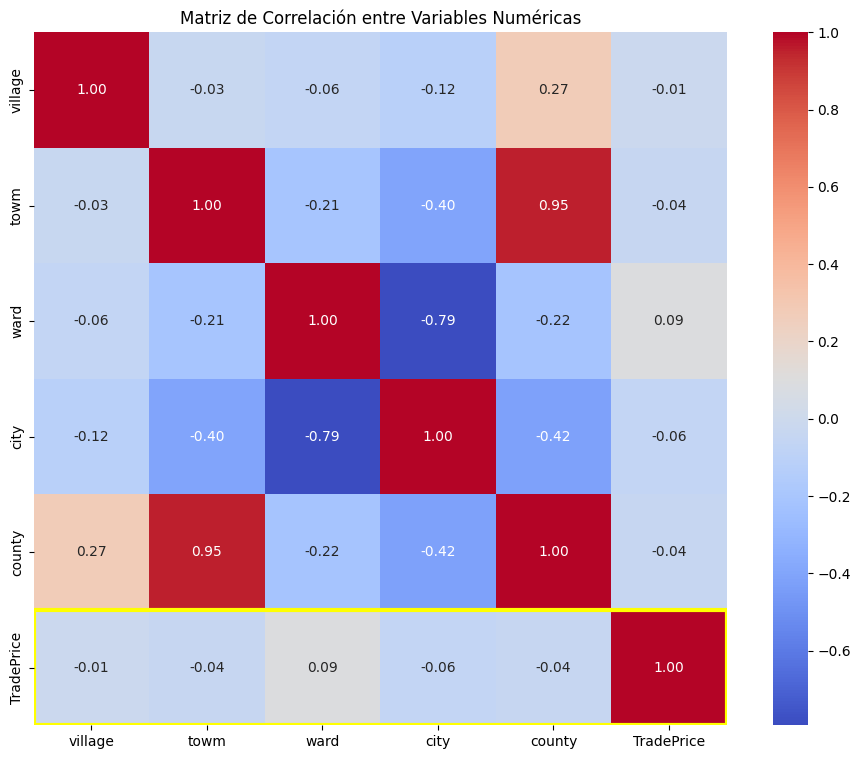

In [21]:

to_test.append("TradePrice")
#to_test.remove("TradePrice")
correlation_heatmap(df[to_test])

In [22]:
def check_kruskal_mannwhitneyu(dfi, categorical_columns, continuos_colum="TradePrice"):
    for var in categorical_columns:
        print(f'\nAnálisis para la columna: {var}')
        
        # Obtener los grupos únicos en la columna categórica actual
        groups = dfi[var].unique()
        
        # Comprobar si hay solo dos grupos para la prueba Mann-Whitney
        if len(groups) == 2:
            group1 = dfi[dfi[var] == groups[0]][continuos_colum]
            group2 = dfi[dfi[var] == groups[1]][continuos_colum]
            
            # Realizar la prueba Mann-Whitney U
            u_stat, p_value_mannwhitney = stats.mannwhitneyu(group1, group2)
            print(f'Mann-Whitney U Test:')
            print(f'U-statistic: {u_stat}, P-value: {p_value_mannwhitney}')
            
            # Visualización
            # sns.boxplot(x=var, y=continuos_colum, data=dfi)
            # plt.title(f'Comparación de precios por {var}')
            # plt.show()
        
        # Realizar la prueba Kruskal-Wallis H si hay más de dos grupos
        if len(groups) > 2:
            target_groups = []
    
            # Usar un bucle for para extraer los datos por grupo
            for group in groups:
                target = dfi[dfi[var] == group][continuos_colum]
                target_groups.append(target)
                
            h_stat, p_value_kruskal = stats.kruskal(*target_groups)
            print(f'Kruskal-Wallis H Test:')
            print(f'H-statistic: {h_stat}, P-value: {p_value_kruskal}')
        
        # Visualización
        # sns.boxplot(x=var, y=continuos_colum, data=dfi)
        # plt.title(f'Comparación de precios por {var}')
        # plt.show()

In [23]:
to_test.remove("TradePrice")
to_test.remove("Municipality")

In [24]:
check_kruskal_mannwhitneyu(df.copy(),to_test)


Análisis para la columna: M
Kruskal-Wallis H Test:
H-statistic: 1537668.3393355, P-value: 0.0

Análisis para la columna: village
Mann-Whitney U Test:
U-statistic: 98484255432.0, P-value: 0.0

Análisis para la columna: towm
Mann-Whitney U Test:
U-statistic: 948804173826.5, P-value: 0.0

Análisis para la columna: ward
Mann-Whitney U Test:
U-statistic: 2273782923065.0, P-value: 0.0

Análisis para la columna: city
Mann-Whitney U Test:
U-statistic: 2182690345426.0, P-value: 0.0

Análisis para la columna: ci_name
Kruskal-Wallis H Test:
H-statistic: 267869.99212236475, P-value: 0.0

Análisis para la columna: county
Mann-Whitney U Test:
U-statistic: 1033089874467.0, P-value: 0.0

Análisis para la columna: co_name
Kruskal-Wallis H Test:
H-statistic: 349537.71975048026, P-value: 0.0


The correlation matrix and kruskal and Mann test results that even though there is no strong linear correlation the data is relevant to the target as the p-values are small.

Due to the large number of categories, I just keep the information gathered in the last step.
The municipality and Municipality Code will be removed. 
Prefecture will be one-hot encoded.
DistrictName will be deleted
NearestStation will be modified and changed to a frequency.

In [25]:
frecuencias = df['NearestStation'].value_counts()

# Calcular el total de estaciones
total_estaciones = len(df)

# Calcular el porcentaje de cada estación
porcentajes = frecuencias / total_estaciones * 100

# Reemplazar los valores en la columna por sus porcentajes
df['NearestStation_Freq'] = df['NearestStation'].map(porcentajes)

In [26]:
df[["TradePrice","NearestStation_Freq"]].corr()
#seems it is not good change

,TradePrice,NearestStation_Freq
TradePrice,1.000000,-0.003244
NearestStation_Freq,-0.003244,1.000000


In [27]:
def make_dummies_analyze(dfi, column_name, target="TradePrice"):
    dummies = pd.get_dummies(dfi[column_name], prefix=column_name, drop_first=False, dtype=int)
    #print("columns dummy", dummies.columns)
    dfi = pd.concat([dfi, dummies], axis=1)
    #print("columns dfi", dfi.columns)
    to_test = [col for col in dfi.columns if column_name in col]
    #print("columns created", to_test)
    to_test.insert(0,target)
    correlation_heatmap(dfi[to_test])
    to_test.remove(target)
    check_kruskal_mannwhitneyu(dfi,to_test)
    return dfi

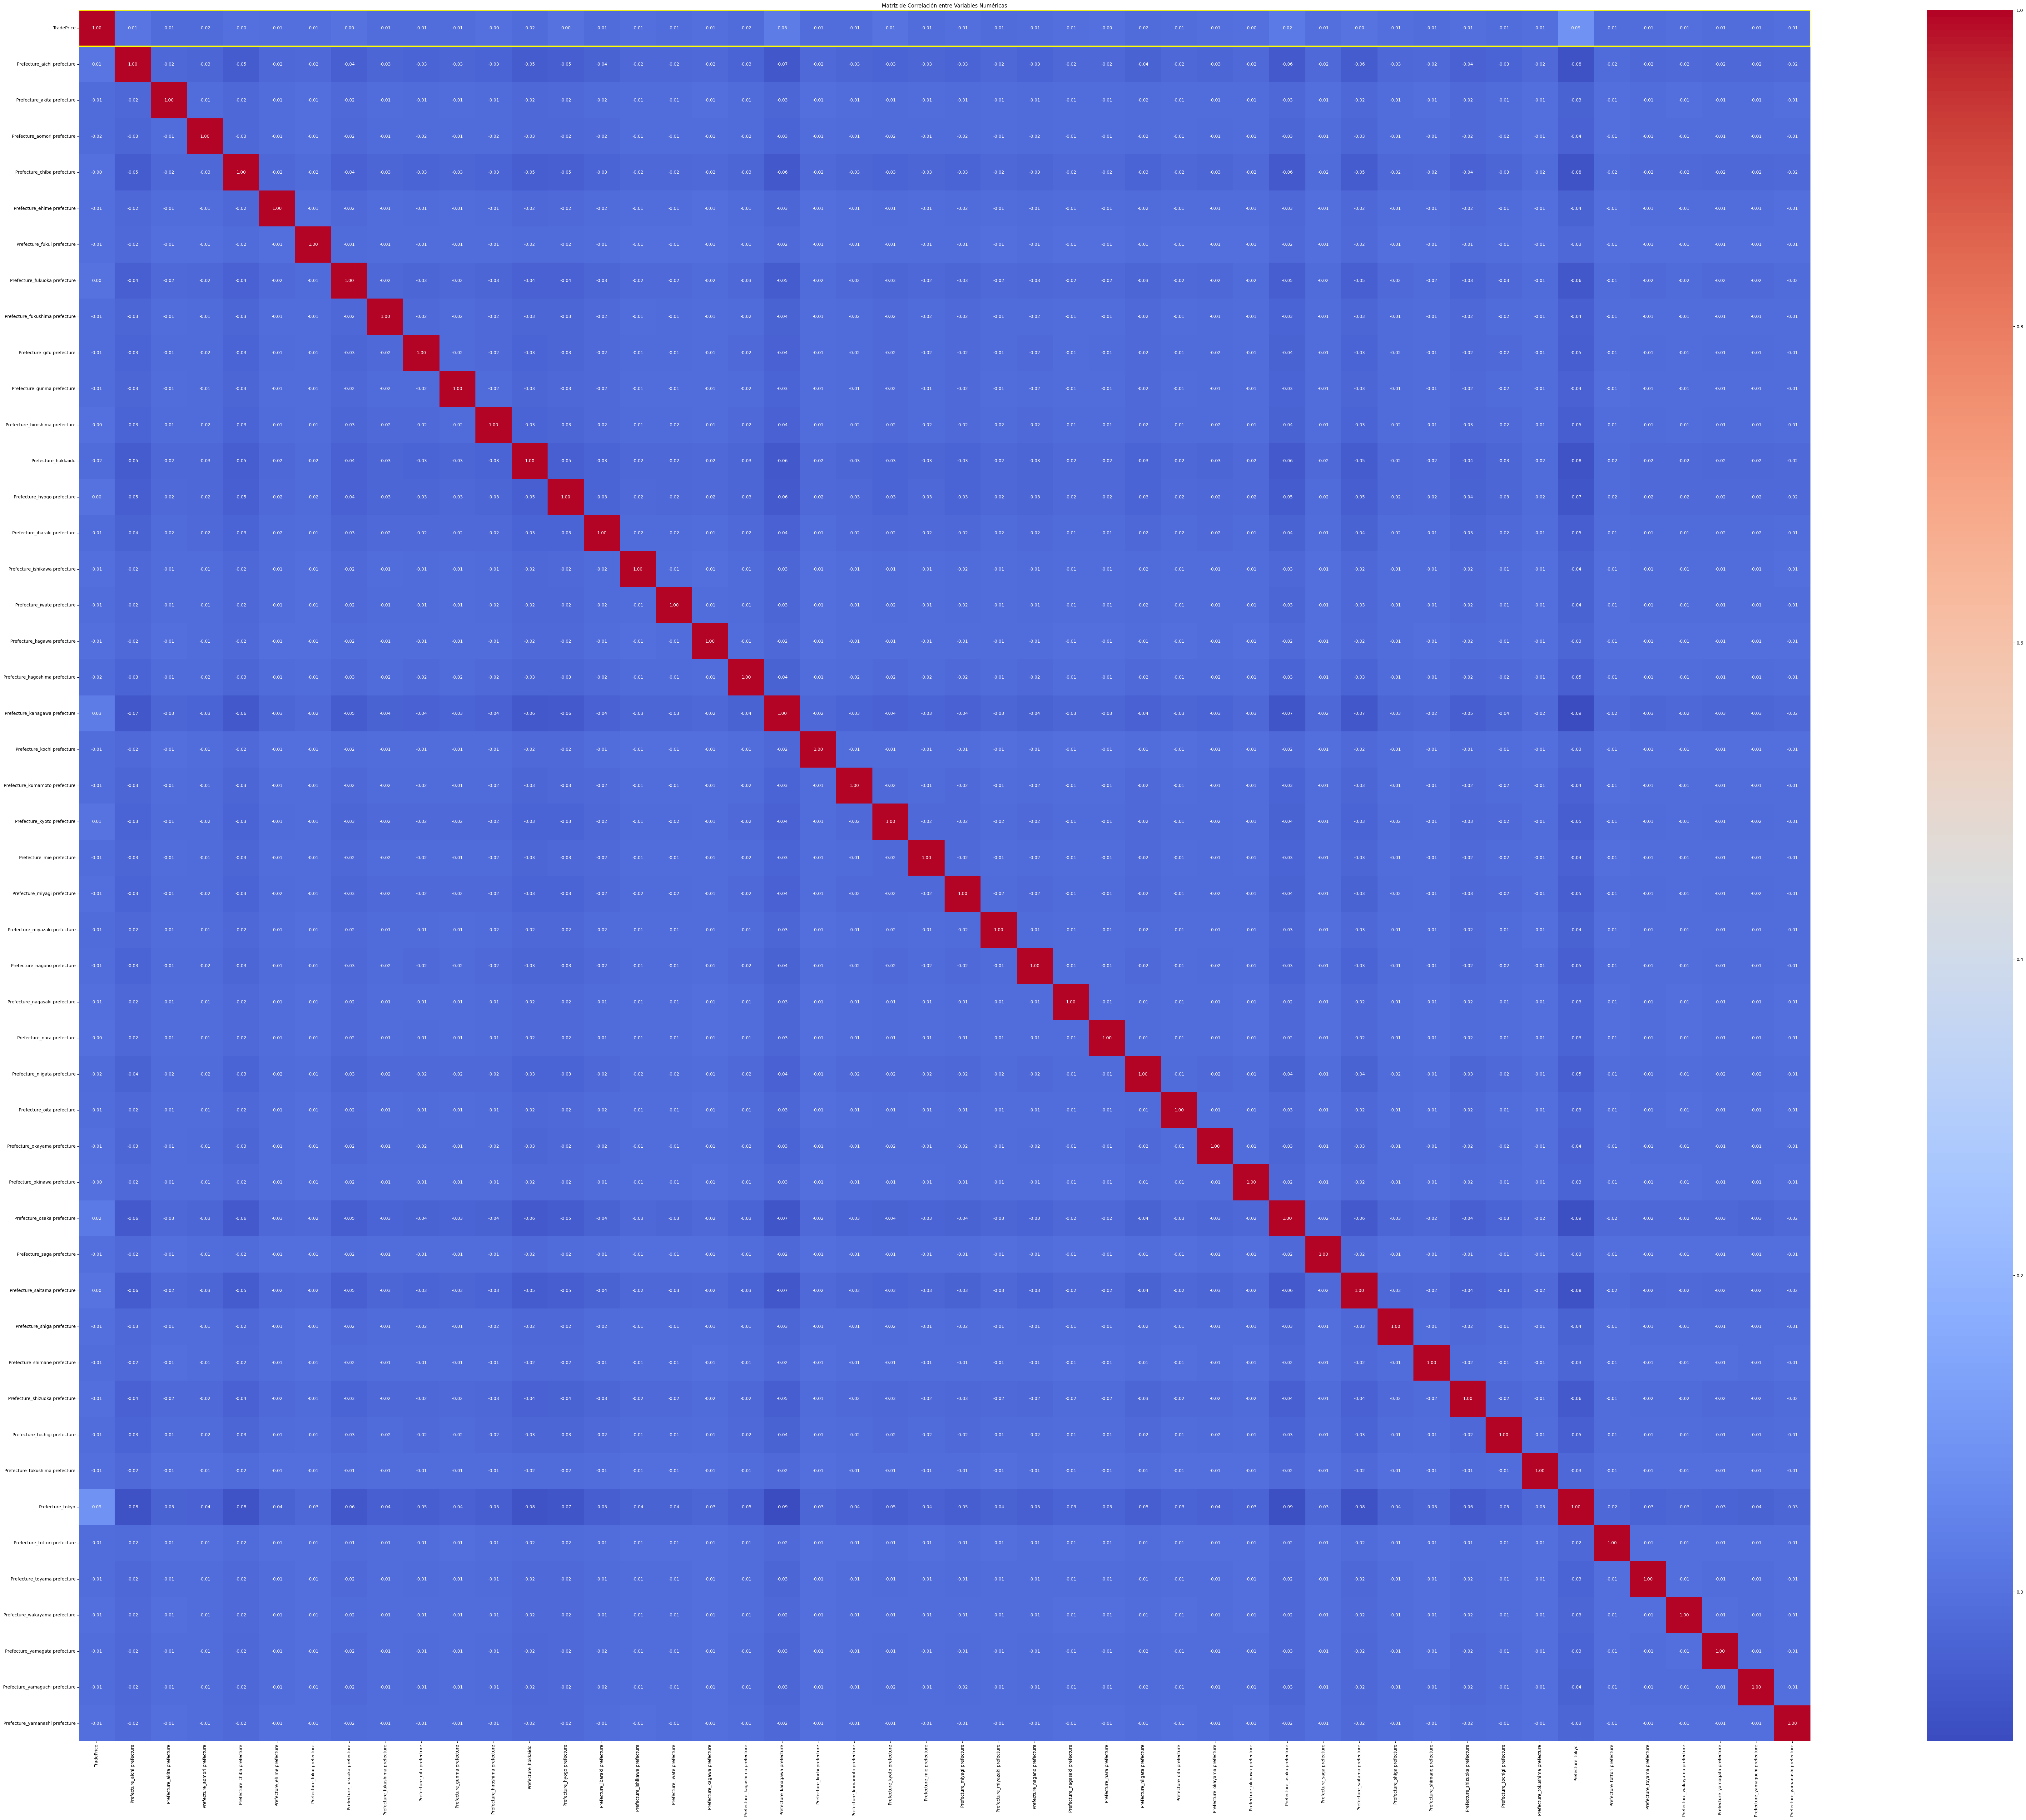


Análisis para la columna: Prefecture
Kruskal-Wallis H Test:
H-statistic: 1080038.5535947469, P-value: 0.0

Análisis para la columna: Prefecture_aichi prefecture
Mann-Whitney U Test:
U-statistic: 278369356777.0, P-value: 0.0

Análisis para la columna: Prefecture_akita prefecture
Mann-Whitney U Test:
U-statistic: 116152164467.0, P-value: 0.0

Análisis para la columna: Prefecture_aomori prefecture
Mann-Whitney U Test:
U-statistic: 146899299759.0, P-value: 0.0

Análisis para la columna: Prefecture_chiba prefecture
Mann-Whitney U Test:
U-statistic: 318399605650.5, P-value: 0.0

Análisis para la columna: Prefecture_ehime prefecture
Mann-Whitney U Test:
U-statistic: 97053230439.0, P-value: 0.0

Análisis para la columna: Prefecture_fukui prefecture
Mann-Whitney U Test:
U-statistic: 54049984716.5, P-value: 0.0

Análisis para la columna: Prefecture_fukuoka prefecture
Mann-Whitney U Test:
U-statistic: 257932216812.0, P-value: 0.001117178420358526

Análisis para la columna: Prefecture_fukushima p

In [28]:
df = make_dummies_analyze(df.copy(),"Prefecture")

The correlation matrix and kruskal and Mann test results that even though there is no strong linear correlation the data is relevant to the target as the p-values are small.

Big data engineering was performed in order to gather the information inside our data. Due to the large amount of categories, they were tyied to be reduced and kept the more generic data to avoid overfitting.
The following steps will be to find a model to predict the TradePrice.
As no linear correlations were clear, tree-based models should perform better than linear ones. Anyway, many models will be tested on our data.

In [29]:
df.columns.to_list()

['MunicipalityCode',
 'Prefecture',
 'Municipality',
 'DistrictName',
 'NearestStation',
 'MinTimeToNearestStation',
 'MaxTimeToNearestStation',
 'TradePrice',
 'Area',
 'AreaIsGreaterFlag',
 'UnitPrice',
 'Frontage',
 'FrontageIsGreaterFlag',
 'TotalFloorArea',
 'TotalFloorAreaIsGreaterFlag',
 'BuildingYear',
 'PrewarBuilding',
 'Breadth',
 'CoverageRatio',
 'FloorAreaRatio',
 'Year',
 'Quarter',
 'Perfect_Price',
 'MaxBaseCoverage',
 'MaxTotalArea',
 'MaxPerfectPrice',
 'CoveragePerfectPrice',
 'Renovation_done',
 'Renovation_not yet',
 'Region_commercial area',
 'Region_industrial area',
 'Region_potential residential area',
 'Region_residential area',
 'Type_agricultural land',
 'Type_forest land',
 'Type_pre-owned condominiums, etc.',
 'Type_residential land(land and building)',
 'Type_residential land(land only)',
 'LandShape_flag-shaped etc.',
 'LandShape_irregular shaped',
 'LandShape_rectangular shaped',
 'LandShape_semi-rectangular shaped',
 'LandShape_semi-shaped',
 'LandSha

In [30]:
df = df.drop(columns=to_delete)

In [31]:
df.columns.to_list()

['MinTimeToNearestStation',
 'MaxTimeToNearestStation',
 'TradePrice',
 'Area',
 'AreaIsGreaterFlag',
 'UnitPrice',
 'Frontage',
 'FrontageIsGreaterFlag',
 'TotalFloorArea',
 'TotalFloorAreaIsGreaterFlag',
 'BuildingYear',
 'PrewarBuilding',
 'Breadth',
 'CoverageRatio',
 'FloorAreaRatio',
 'Year',
 'Quarter',
 'Perfect_Price',
 'MaxBaseCoverage',
 'MaxTotalArea',
 'MaxPerfectPrice',
 'CoveragePerfectPrice',
 'Renovation_done',
 'Renovation_not yet',
 'Region_commercial area',
 'Region_industrial area',
 'Region_potential residential area',
 'Region_residential area',
 'Type_agricultural land',
 'Type_forest land',
 'Type_pre-owned condominiums, etc.',
 'Type_residential land(land and building)',
 'Type_residential land(land only)',
 'LandShape_flag-shaped etc.',
 'LandShape_irregular shaped',
 'LandShape_rectangular shaped',
 'LandShape_semi-rectangular shaped',
 'LandShape_semi-shaped',
 'LandShape_semi-square shaped',
 'LandShape_semi-trapezoidal shaped',
 'LandShape_square shaped',

In [32]:
df.to_csv('EDA-Fase3.csv', index=False, header=True)